In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
from datetime import datetime, timedelta
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf

In [29]:
start_date = datetime(2013,1,1)
end_date = datetime(2022, 6, 1)

## Reading Stock data


In [30]:
symbol = 'AAPL'
apple_data = yf.Ticker(symbol)

In [31]:
prices = apple_data.history(start=start_date, end=end_date).Close

In [32]:
# multiplied by 100 to convert return to percent
daily_returns = 100 * (prices.pct_change().dropna())

Text(0, 0.5, 'Pct Returns')

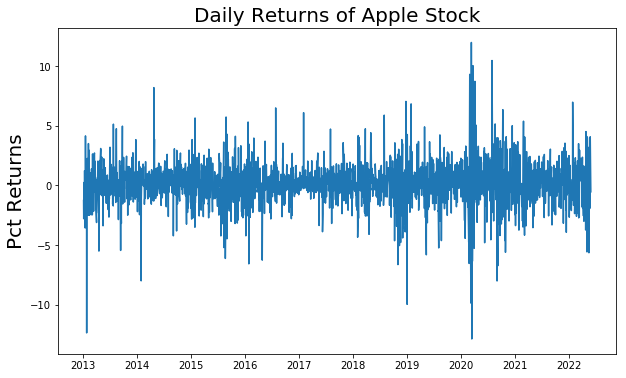

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(daily_returns)
plt.title("Daily Returns of Apple Stock", fontsize=20)
plt.ylabel("Pct Returns", fontsize=20)

## It can be observed that returns are quite volatile, so, we can try to fit a Garch model in this return time series to find out or predict the volatility of returns tomorrow.

# Plot PACF on returns square time series to find out lag inclusion in volatility prediction model 

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


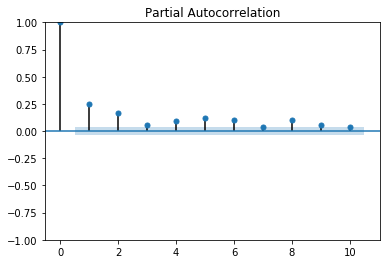

In [34]:
plot_pacf(daily_returns**2, lags=10)
plt.show()

## Many lags are significant but we will only include 2 lags to keep model simple and also PACF plot shuts off quite significantly after lag=2

In [38]:
model = arch_model(daily_returns, p = 2, q = 2)

In [39]:
model_fit = model.fit(disp='off')

In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4527.90
Distribution:                  Normal   AIC:                           9067.80
Method:            Maximum Likelihood   BIC:                           9102.43
                                        No. Observations:                 2369
Date:                Mon, Jul 18 2022   Df Residuals:                     2368
Time:                        15:10:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1725  3.432e-02      5.026  5.020e-07 [  0.105,  0.240]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3109      0.154      2.020  4.336e-02  [9.270e-03,  0.613]
alpha[1]       0.1207  4.113e-02      2.934  3.345e-03  [4.007e-02,  0.201]
alpha[2]       0.0850  4.838e-02      1.758  7.882e-02 [-9.793e-03,  0.180]
beta[1]        0.1030      0.688      0.150      0.881    [ -1.245,  1.451]
beta[2]        0.5959      0.573      1.039      0.299    [ -0.528,  1.720]
===========================================================================

Covariance estimator: robust
"""

## p-values and beta coefficients does not seems to be significant in the model fit, so, better to drop them from the model and only inludes the lagged time series coefficents, not the volatility one which implies our model will become ARCH model

In [41]:
model = arch_model(daily_returns, p =2, q=0)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4616.58
Distribution:                  Normal   AIC:                           9241.17
Method:            Maximum Likelihood   BIC:                           9264.25
                                        No. Observations:                 2369
Date:                Mon, Jul 18 2022   Df Residuals:                     2368
Time:                        15:35:06   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1429  3.787e-02      3.773  1.610e-04 [6.867e-02,  0.217]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.9921      0.175     11.389  4.736e-30   [  1.649,  2.335]
alpha[1]       0.1840  4.697e-02      3.917  8.949e-05 [9.194e-02,  0.276]
alpha[2]       0.2183  5.019e-02      4.349  1.369e-05   [  0.120,  0.317]
==========================================================================

Covariance estimator: robust
"""

## Now coefficients seems like statistically significant, so, we can use this

In [46]:
rolling_forecast = []
test_size = 365 # Initial dataset, we can keep on incrementing it one by one to increase our training dataset

for i in range(test_size):
    train = daily_returns[:-(test_size-i)]
    model = arch_model(train, p = 2, q = 0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = True)
    values = np.sqrt(pred.variance.values[-1,:][0])
    rolling_forecast.append(values)

In [49]:
df_forecast_vol = pd.Series(rolling_forecast, index = daily_returns.index[-365:])

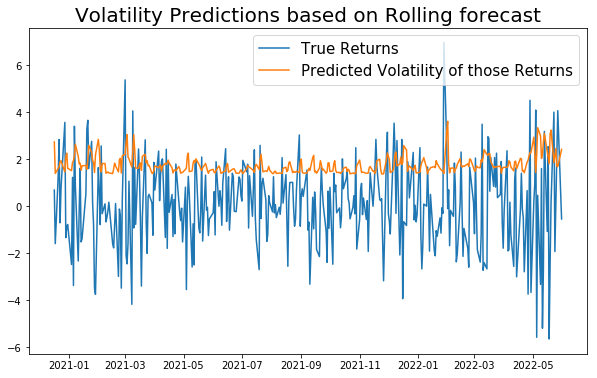

In [50]:
plt.figure(figsize=(10,6))
true, = plt.plot(daily_returns[-365:])
pred, = plt.plot(df_forecast_vol)
plt.title("Volatility Predictions based on Rolling forecast", fontsize=20)
plt.legend(["True Returns", "Predicted Volatility of those Returns"], fontsize=15)

## We will try to run the same process on the S&P to observe how it behaves on that for a long period 

In [61]:
start = datetime(2000,1,1)
end = datetime(2022,6,1)
symbol = 'SPY'
data = yf.Ticker(symbol)
snp_prices = data.history(start=start, end=end).Close

In [62]:
daily_returns_snp = 100 * (snp_prices.pct_change().dropna())

Text(0, 0.5, 'PcT Returns')

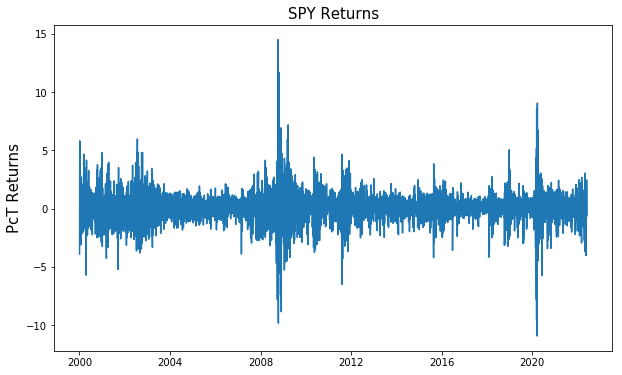

In [64]:
plt.figure(figsize=(10,6))
plt.plot(daily_returns_snp)
plt.title("SPY Returns", fontsize = 15)
plt.ylabel("PcT Returns", fontsize = 15)

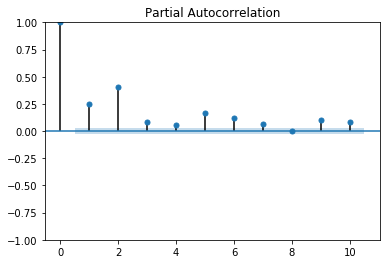

In [69]:
plot_pacf(daily_returns_snp**2, lags=10)
plt.show()

## Start with Garch 2,2

In [71]:
model = arch_model(daily_returns_snp, p =2, q=2)
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7747.21
Distribution:                  Normal   AIC:                           15506.4
Method:            Maximum Likelihood   BIC:                           15546.2
                                        No. Observations:                 5638
Date:                Mon, Jul 18 2022   Df Residuals:                     5637
Time:                        17:08:41   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0735  1.063e-02      6.919  4.564e-12 [5.271e-02,9.438e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0449  9.741e-03      4.611  4.004e-06 [2.582e-02,6.401e-02]
alpha[1]       0.0876  2.163e-02      4.048  5.160e-05   [4.518e-02,  0.130]
alpha[2]       0.1387  2.461e-02      5.639  1.714e-08   [9.051e-02,  0.187]
beta[1]        0.2354      0.229      1.027      0.304     [ -0.214,  0.685]
beta[2]        0.5064      0.203      2.495  1.258e-02     [  0.109,  0.904]
============================================================================

Covariance estimator: robust
"""

## Although Beta 1 is not significant but we will do the judgement call to keep it

In [ ]:
rolling_forecast_snp = []
test_size = 365*5 # last 5 years

for i in range(test_size):
    train = daily_returns_snp[:-(test_size-i)]
    model = arch_model(train, p = 2, q = 0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = True)
    values = np.sqrt(pred.variance.values[-1,:][0])
    rolling_forecast_snp.append(values)

In [ ]:
df_forecast_vol = pd.Series(rolling_forecast, index = daily_returns.index[-365:])
plt.figure(figsize=(10,6))
true, = plt.plot(daily_returns[-365:])
pred, = plt.plot(df_forecast_vol)
plt.title("Volatility Predictions based on Rolling forecast", fontsize=20)
plt.legend(["True Returns", "Predicted Volatility of those Returns"], fontsize=15)